# Konvoluční sítě

Na přednášce jste se bavili o konvolučních sítích, které si dnes se vyzkoušíme i na cvičení. Navíc si ukážeme i tensorboard a knihovnu pro vytváření matoucích vzorů.

Implementovat konvoluční síť v tensorflow je skoro stejné jako implementace jiných architektur. Než se dostaneme k samotným modelům, podíváme se na tři často používané datasety.  

In [1]:
import random

import numpy as np

import tensorflow as tf

from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist

import matplotlib.pyplot as plt
%matplotlib inline

Prvním z nich je dataset MNIST, který obsahuje 60,000 trénovacích a 10,000 testovacích černobílých obrázků číslic 0-9, každý normalizovaný do velikosti 28x28 pixelů. Každá třída obsahuje stejný počet obrázků.

In [2]:
# Function to render the images
def show_dataset_examples(X, y, labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        idx = random.randint(0, X.shape[0]) 
        plt.subplot(5, 5, i+1)
        plt.imshow(X[idx])
        plt.title(labels[y[idx]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

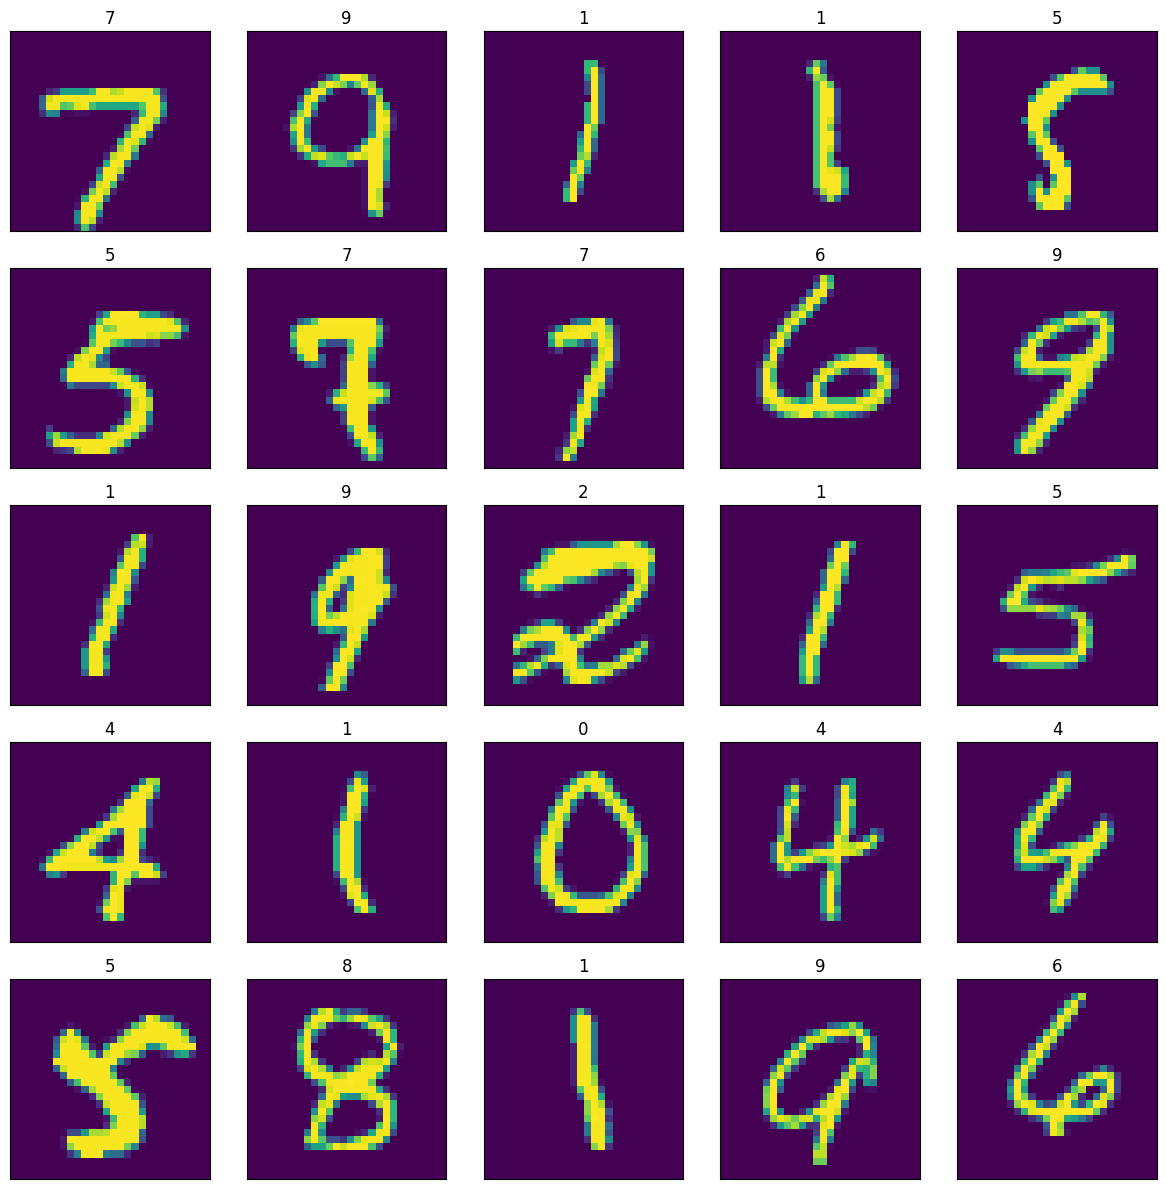

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
mnist_class_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
show_dataset_examples(x_train, y_train, mnist_class_labels)

Druhým je Fashion-MNIST, který se skládá z 60,000 trénovacích a 10,000 testovacích černobílých obrázků oblečení. Každý z nich je o rozměrech 28x28 pixelů a patří do jedné z 10 tříd: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot.

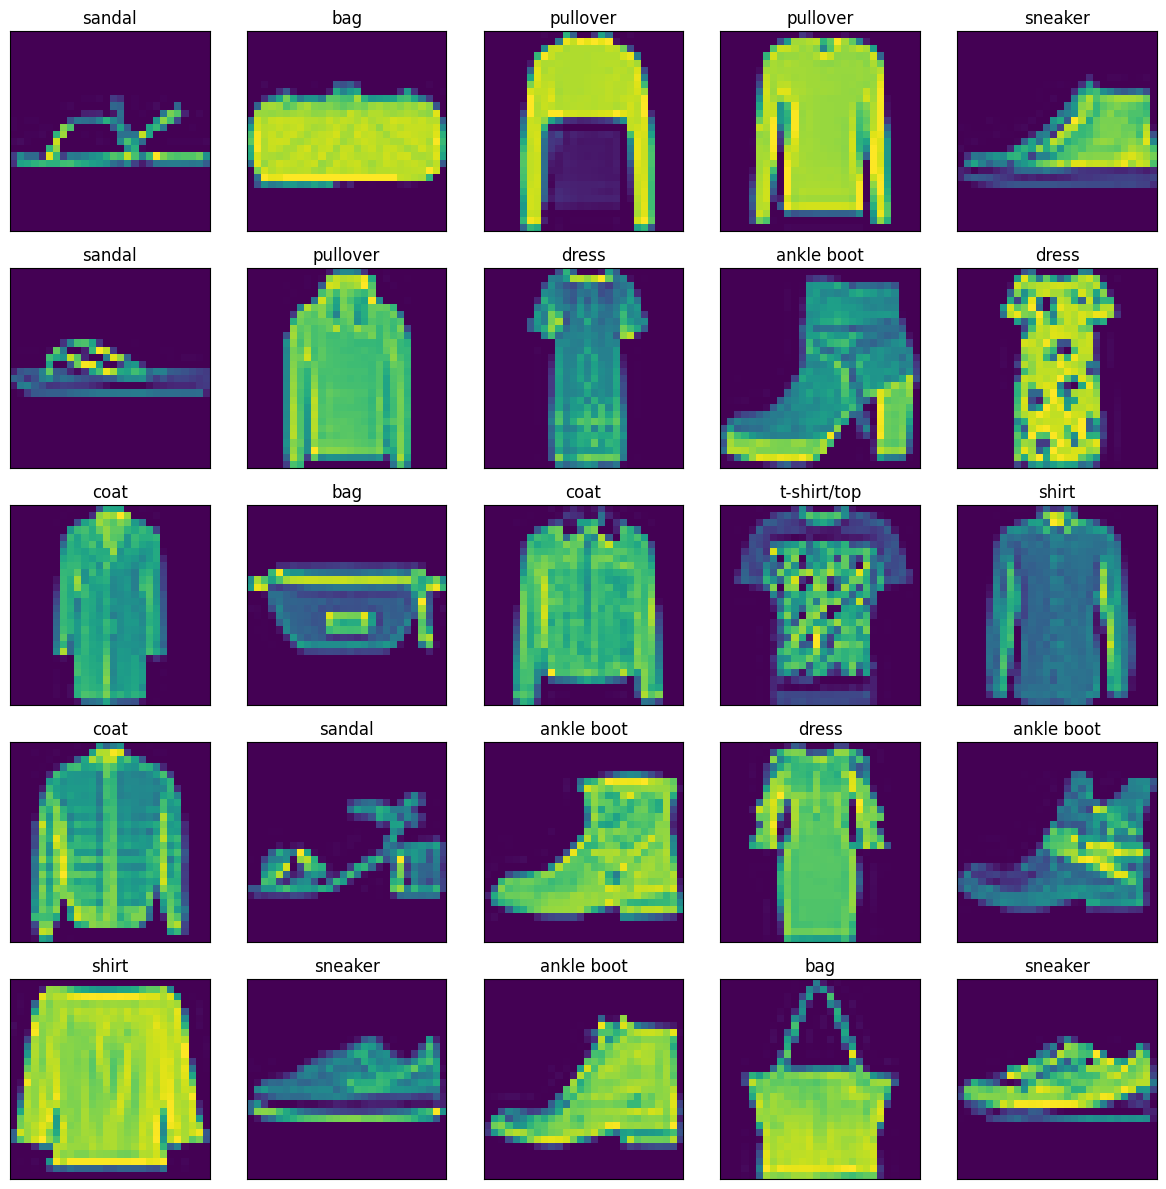

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
mnist_class_labels = ["t-shirt/top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
show_dataset_examples(x_train, y_train, mnist_class_labels)

Posledním je CIFAR10, který obsahuje 50,000 trénovacích a 10,000 testovacích barevných obrázků z 10 různých tříd: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Obrázky jsou velikosti 32x32 pixelů a každá třída obsahuje přesně 5,000 obrázků. Existuje i verze CIFAR100, která obsahuje 100 výstupních labelů.

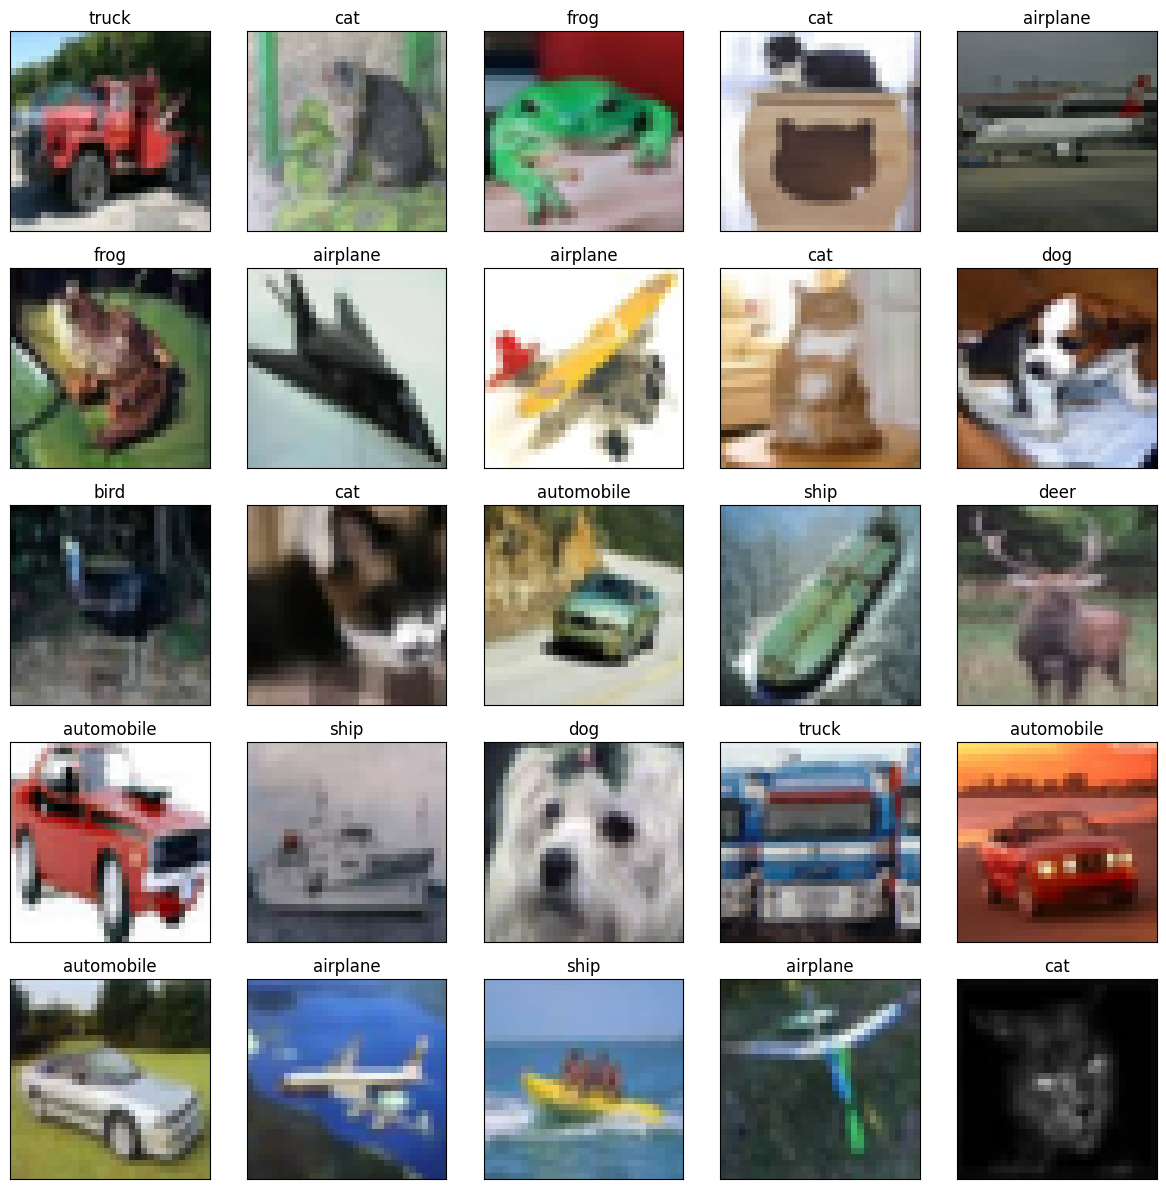

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

cifar_class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
show_dataset_examples(x_train/255, list(map(lambda x: x[0], y_train)), cifar_class_labels)

Nyní se podíváme na samotné konvoluční sítě. Zkusíme si jednu vytvořit a natrénovat ji na klasifikaci číslic z MNISTu. Podíváme-li se na samotný model, vidíme, že se skládá z několika vrstev.
- ```InputLayer``` je vrstva určená jako vstup do sítě s jedním parametrem rozměrů vstupu - nic nedělá, je jen vstupním bodem do sítě.
- ```Conv2D``` je 2D konvoluční vrstva s parametry počet filtrů v konvoluci a velikostí 2D konvolučního okénka / kernelu.
- ```MaxPool2D``` je vrstva pro zmenšení dimenzionality vstupu, která má parametry počet kroků a velikost toho, jak se má obrázek zmenšovat v obou dimenzích ((2,2) znamená, že se zmenší v obou rozměrech na polovinu). 
- ```Flatten``` je zploštující vrstva, tedy ze vstupu rozměrů (a,b) udělá výstup o rozměru a*b
- ```Dense``` je jen obyčejná plně propojená vrstva se zadanou aktivací (V podstatě náš starý známý z vícevrstvých perceptronů).
- ```Activation``` je vrstva, která vstup jen prožene zadanou aktivační funkcí.

Když nyní rozumíme jednotlivým vrstvám, můžeme se podívat na samotné trénovaní a vyhodnocení modelu.

In [6]:
# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

nb_classes = 10
input_shape = (28, 28, 1)

x_train = x_train.reshape((-1,) + input_shape) / 255
x_test = x_test.reshape((-1,) + input_shape) / 255

# Define model
model = tf.keras.models.Sequential([])
model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5)))
model.add(tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPool2D(strides=2, pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten(name="Flatten"))
model.add(tf.keras.layers.Dense(units=30, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=nb_classes, activation=tf.keras.activations.linear, name="logits"))
model.add(tf.keras.layers.Activation(activation=tf.nn.softmax))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=2)
pass

Epoch 1/2
469/469 [==============================] - 10s 16ms/step - loss: 0.2471 - accuracy: 0.9271
Epoch 2/2
469/469 [==============================] - 7s 16ms/step - loss: 0.0659 - accuracy: 0.9803


In [7]:
# Compute an accuracy on our test data
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 7ms/step - loss: 0.0517 - accuracy: 0.9835


[0.05167936533689499, 0.9835000038146973]

## Matoucí vzory

In [ ]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

Na přednášce jste se bavili i o tom, že konvoluční sítě lze docela snadno zmást pomocí tzv. matoucích vzorů. Matoucí vzory můžeme vygenerovat například pomocí knihovny cleverhans. Tato knihovna potřebuje tensor aktivací před poslední (softmax) vrstvou. Tu jsme si ale pojmenovali logits, není tedy problém si ji z našeho modelu snadno vzít a zašumět ji. To se dělá tak, že se spočítá derivace chyby podle vstupního obrázku, z toho se udělá signum, pronásobí se epsilonem a přičte se ke vstupu. Epsilon je pole hodnot, které obsahuje různé míry zašumění a můžeme tedy dobře sledovat, jak jeho hodnota zašumělost ovlivňuje.

In [8]:
logits = tf.keras.Model(model.inputs, model.get_layer("logits").output)

results = {}
epsilon_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for epsilon in epsilon_vals:
    adversarial_x = fast_gradient_method(logits, x_test, epsilon, norm=np.inf)
    r = model.evaluate(adversarial_x, y_test)[1]
    results[epsilon] = r

print("Accuracies:")
print(results)

313/313 [==============================] - 2s 7ms/step - loss: 17.3312 - accuracy: 0.0120
Accuracies:
{0.0: 0.9835000038146973, 0.05: 0.8384000062942505, 0.1: 0.40860000252723694, 0.15: 0.11640000343322754, 0.2: 0.03400000184774399, 0.25: 0.017799999564886093, 0.3: 0.014299999922513962, 0.35: 0.013000000268220901, 0.4: 0.012000000104308128}


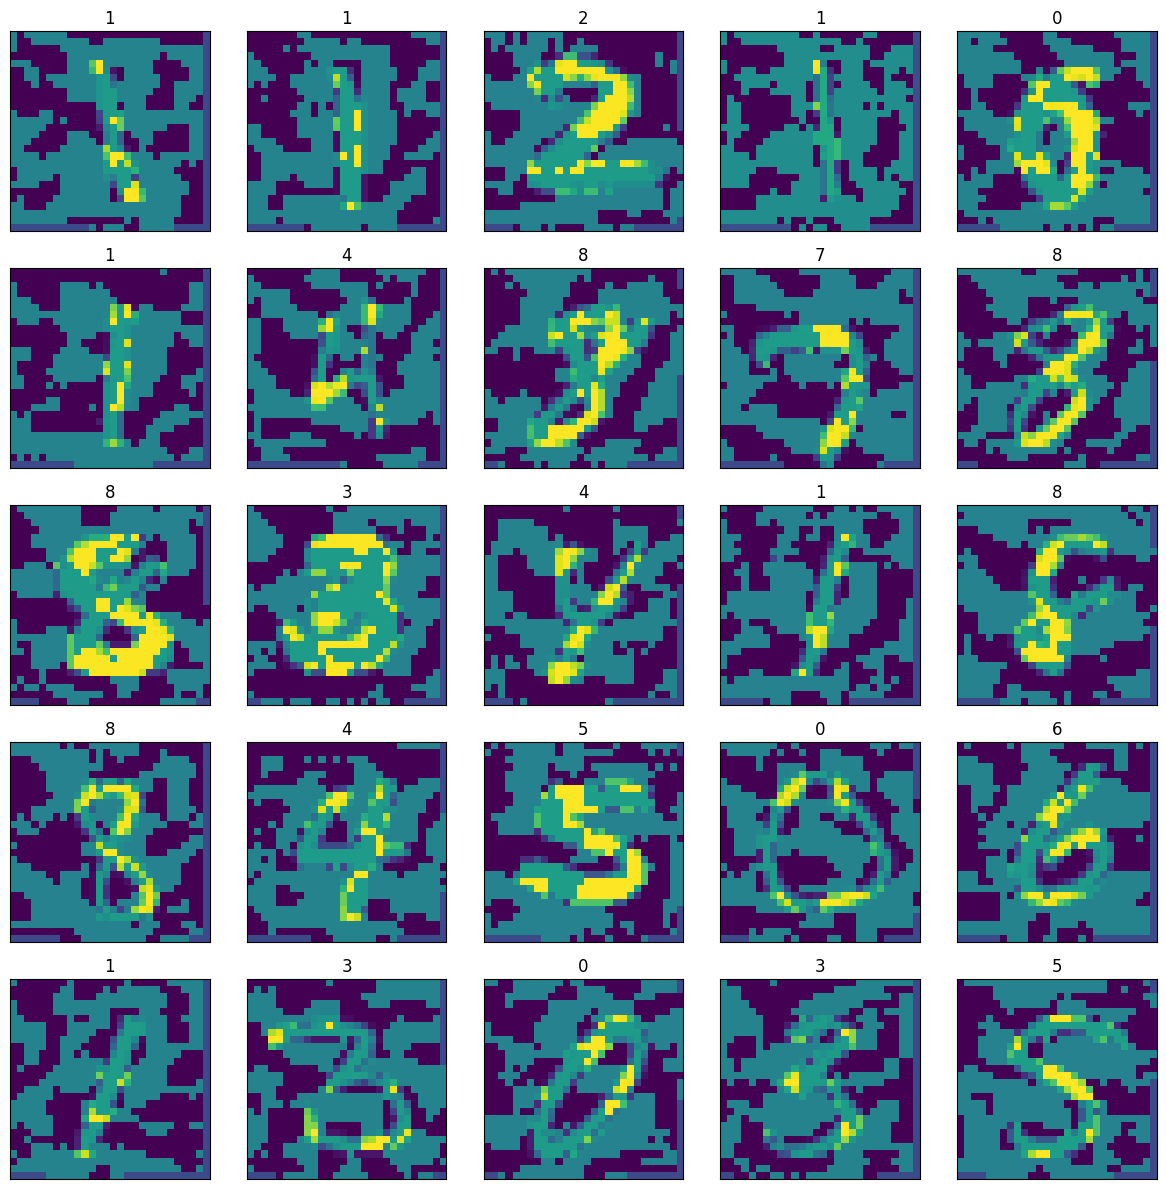

In [10]:
# Let's render the adversarial patterns
mnist_class_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
adversarial_x = tf.reshape(adversarial_x, (-1, 28, 28))
show_dataset_examples(adversarial_x, y_test, mnist_class_labels)

## Úkol na cvičení

Zkuste si natrénovat zašumnělé vzory i pro CIFAR10 dataset a porovnat, jak moc je těžší, než MNIST. Zároveň si zkuste natrénovat konvoluční síť na Fashion-MNIST a najít nejčastější chyby, kterých se síť při klasifikaci dopouští.


## Image classification

[ImageNet](http://www.image-net.org/) je výzkumý projekt pro vyvíjení velké databáze anotovaných obrázků, tj. obrázků a jejich popisů. Na nich se dají trénovat konvoluční sítě například pro image classification úlohu. Bohužel natrénovat takovou síť na takto obrovských datech trvá řádově dny až týdny na grafických kartách. Naštěstí knihovna keras obsahuje některé modely už s předtrénovanými vahami, takže je nemusíme trénovat celé znovu. Jako příklad můžeme vzít třeba modely [The Oxford VGG Models](https://www.robots.ox.ac.uk/~vgg/research/very_deep/). My se teď podíváme, jak vypadá jeden z nich, konkrétně VGG16, který je trénovaný na obrázcích z ImageNetu na predikci 1000 různých tříd.

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from keras.applications.vgg16 import VGG16

model = VGG16()
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Když víme, jaké model obsahuje vrstvy a jak vypadá, zkusíme si načíst nějaký obrázek a nechat model, aby predikoval, co na něm je.

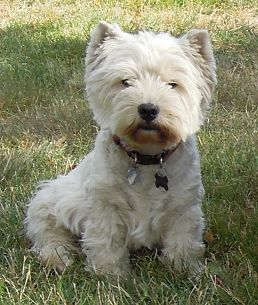

In [13]:
from PIL import Image
Image.open("dog.png")

In [15]:
# Load image
image = load_img("dog.png", target_size=(224, 224))
# Convert pixels to NumPy array
image = img_to_array(image)
# Reshape of the image for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# Prepare image for VGG model
image = preprocess_input(image)
# Predict probabilities for all classes
prediction = model.predict(image)
# Convert probabilities to labels
labels = decode_predictions(prediction)
# Select the one with maximum probability
label = labels[0][0]
print("%s (%.2f%%)" % (label[1], label[2]*100))
print(labels)

West_Highland_white_terrier (87.87%)
[[('n02098286', 'West_Highland_white_terrier', 0.8786723), ('n02085936', 'Maltese_dog', 0.03810152), ('n02094114', 'Norfolk_terrier', 0.02069879), ('n02095889', 'Sealyham_terrier', 0.018502643), ('n02097298', 'Scotch_terrier', 0.010451282)]]


Pokud bychom se chtěli podívat na všech 1000 tříd, stačí nám k predikcím přidat parametr, že chceme prvních 1000 labelů.

In [16]:
labels = decode_predictions(prediction, top=1000)
labels = labels[0][:]
labels = [y for (x,y,z) in labels]
# print(labels)

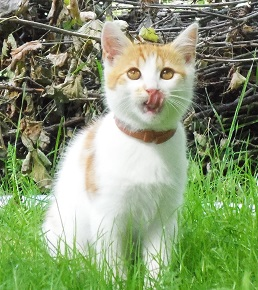

In [17]:
from PIL import Image
Image.open("cat.png")

In [18]:
# Load image
image = load_img("cat.png", target_size=(224, 224))
# Convert pixels to NumPy array
image = img_to_array(image)
# Reshape of the image for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# Prepare image for VGG model
image = preprocess_input(image)
# Predict probabilities for all classes
prediction = model.predict(image)
# Convert probabilities to labels
labels = decode_predictions(prediction)
# Select the one with maximum probability
label = labels[0][0]
print("%s (%.2f%%)" % (label[1], label[2]*100))
print(labels)

tiger_cat (58.94%)
[[('n02123159', 'tiger_cat', 0.5893769), ('n02123045', 'tabby', 0.10447712), ('n02124075', 'Egyptian_cat', 0.087404944), ('n02441942', 'weasel', 0.040245038), ('n02123597', 'Siamese_cat', 0.023020746)]]
